# Trabajo de vision 2D

### Declaracion de funciones

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import math
def calc_dist(p1,p2):
    #Calcular distancia de dos puntos 2D
    temp = (p1-p2)**2
    res = math.sqrt(temp[0]+temp[1])
    return res

def rotate_image(array, angle):
    #funcion para rotar la imagen sin eliminar trozos de la imagen
    height, width = array.shape[:2]
    image_center = (width / 2, height / 2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1)
    mat_rot = rotation_mat
    radians = math.radians(angle)
    sin = math.sin(radians)
    cos = math.cos(radians)
    bound_w = int((height * abs(sin)) + (width * abs(cos)))
    bound_h = int((height * abs(cos)) + (width * abs(sin)))

    rotation_mat[0, 2] += ((bound_w / 2) - image_center[0])
    rotation_mat[1, 2] += ((bound_h / 2) - image_center[1])

    rotated_mat = cv2.warpAffine(array, rotation_mat, (bound_w, bound_h))
    return rotated_mat,rotation_mat

def averiguar_puntoVert(box):
    #funcion que devuelve el indice del punto que hace la recta vertical de la carta y
    #el indice del punto con la recta diagonal que une las dos esquinas mas lejanas
    dist_min = 9999999 
    dist_max = 0
    for n in range(1,len(box)):
        dist = calc_dist(box[0],box[n])
        if dist > dist_max:
            dist_max=dist
            esquina = n
        if dist < dist_min:
            dist_min=dist
        if(n==1):
            indice_punto = n
        if dist > dist_min and dist < dist_max:
            indice_punto = n
    return indice_punto,esquina
def find_lowest_x_y(points):
    # Initialize the minimum x and y values with the first point in the list
    min_x = points[0][0]
    max_y = points[0][1]
    
    for point in points:
        if point[0] < min_x:
            min_x = point[0]
        if point[1] > max_y:
            max_y = point[1]
            
    return min_x, max_y

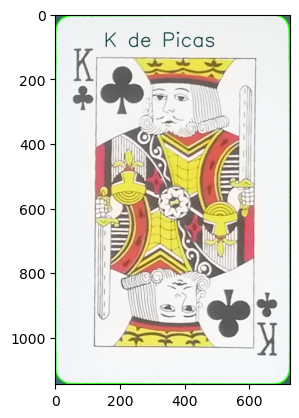

Imagen Guardada en: Result/Image0.jpg


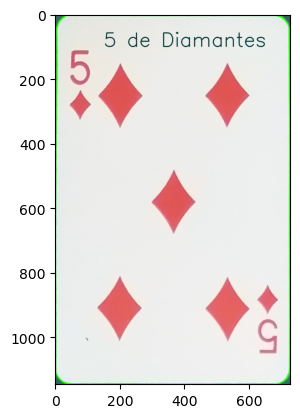

Imagen Guardada en: Result/Image1.jpg


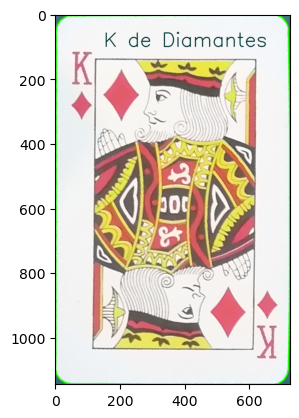

Imagen Guardada en: Result/Image2.jpg


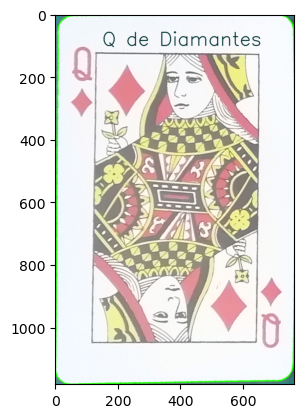

Imagen Guardada en: Result/Image3.jpg


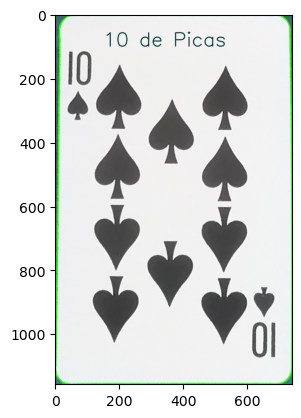

Imagen Guardada en: Result/Image4.jpg


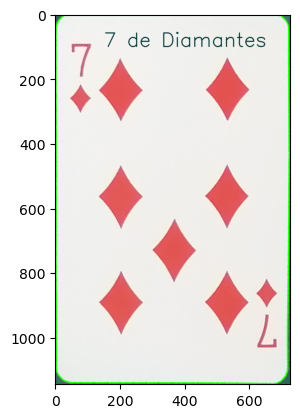

Imagen Guardada en: Result/Image5.jpg


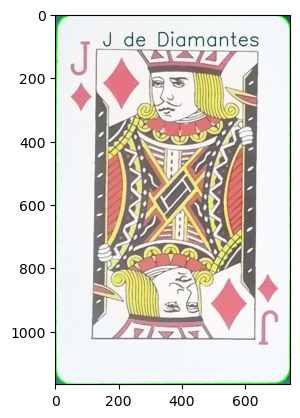

Imagen Guardada en: Result/Image6.jpg


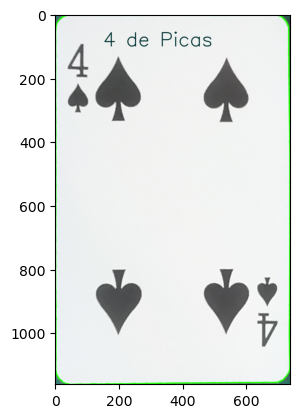

Imagen Guardada en: Result/Image7.jpg


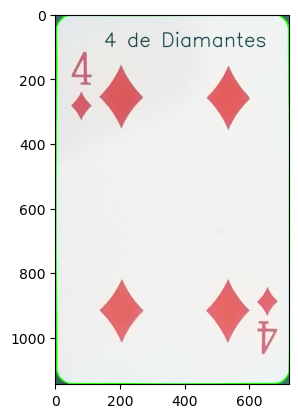

Imagen Guardada en: Result/Image8.jpg


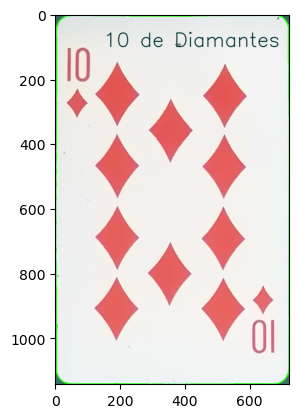

Imagen Guardada en: Result/Image9.jpg


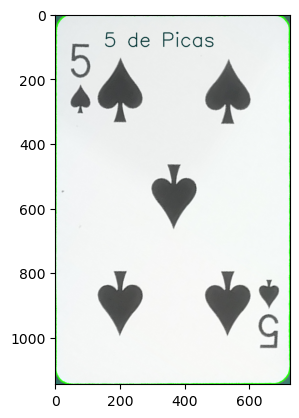

Imagen Guardada en: Result/Image10.jpg


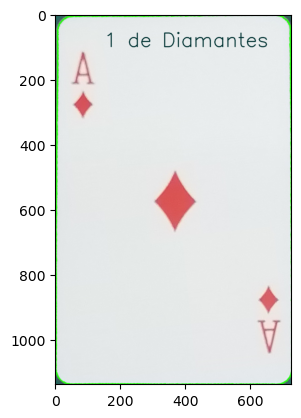

Imagen Guardada en: Result/Image11.jpg


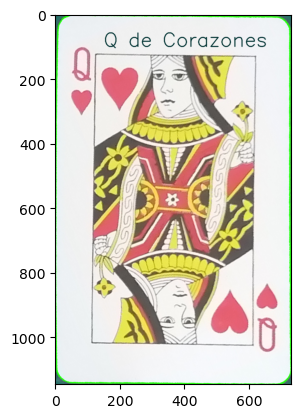

Imagen Guardada en: Result/Image12.jpg


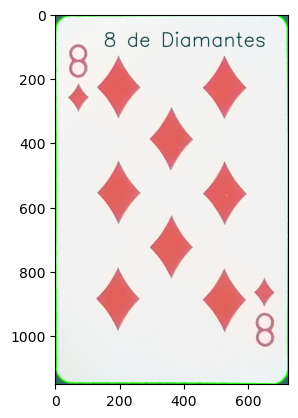

Imagen Guardada en: Result/Image13.jpg


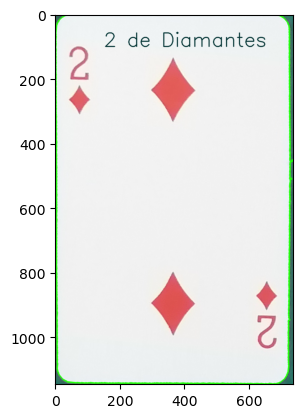

Imagen Guardada en: Result/Image14.jpg


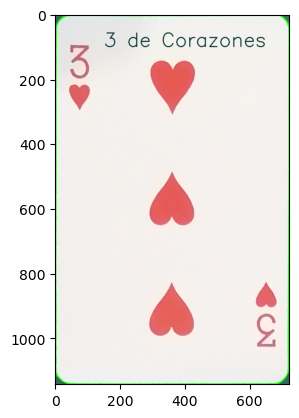

Imagen Guardada en: Result/Image15.jpg


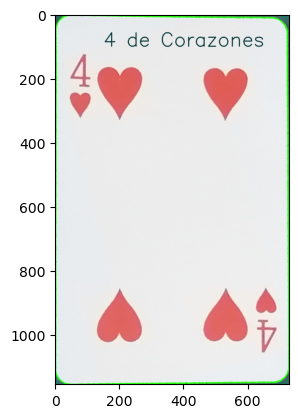

Imagen Guardada en: Result/Image16.jpg


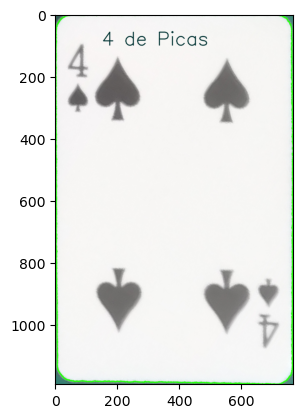

Imagen Guardada en: Result/Image17.jpg


In [36]:
### import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import math
indice=0
cv_img = []
for img in glob.glob("Fotos_Poker_1/*.jpg"):
    n= cv2.imread(img)
    n_rgb = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    cv_img.append(n_rgb)
for n in range(len(cv_img)):
    img = cv_img[n]
    img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_g,170,255,0)
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    threshold_min_area = 12000
    number_of_contours = 0
    card_cont = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area > threshold_min_area:
            cv2.drawContours(img, [c], 0, (36,255,12), 3)
            number_of_contours += 1
            card_cont.append(c)
    for i in range(len(card_cont)):
        #Para todas las cartas que se detectaron contornos hago el menor rectangulo que las abarca.
        rot_rect = cv2.minAreaRect(card_cont[i])
        box = cv2.boxPoints(rot_rect)
        box = box.astype(int)
        for p in box:
            pt = (p[0],p[1])
            #print(pt)
    
        #dibujar rectangulo en las cartas detectadas
        #rot_bbox = img.copy()
        #cv2.drawContours(rot_bbox,[box],0,(255,0,0),2)
        #plt.imshow(rot_bbox)
    
        n,esquina = averiguar_puntoVert(box)
        ang = np.arcsin(abs(box[0][0]-box[n][0])/calc_dist(box[0],box[n])) #calculo el angulo a corregir de la recta vertical de la carta.
        if(box[0][1]<box[n][1]): # dependiendo de como este girada la rotacion sera positiva o negativa para poner la carta recta.
            img_rot,rotation_mat = rotate_image(img,-ang*180/math.pi)
        else:
            img_rot,rotation_mat = rotate_image(img,ang*180/math.pi)
    
        #conseguimos la matriz de rotacion usada al girar la imagen
        rot_mat = np.array([[rotation_mat[0][0],rotation_mat[0][1]],[rotation_mat[1][0],rotation_mat[1][1]]])
        #calculamos los puntos en la nueva imagen anyadiendo la tercera columna que era la de offset
        pt_init = np.dot(rot_mat,box[0])+rotation_mat[0:2,2]
        pt_end = np.dot(rot_mat,box[esquina])+rotation_mat[0:2,2]
        #recortamos la imagen para contener solo a la carta.
        img_crop = img_rot[int(min(pt_init[1],pt_end[1])):int(max(pt_end[1],pt_init[1])),int(min(pt_init[0],pt_end[0])):int(max(pt_end[0],pt_init[0]))]
        plt.imshow(img_crop)
        
        rs=cv2.resize(img_crop, (800, int(800*1.53)))#hago la imagen de un tamanyo determinado siempre, para comparar con las templates
        rs1 = rs[0:int(400*1.53),0:400+100] #recorto la imagen a 1/4 de su tamanyo mas un pequenyo margen para comparar si es el 2
        
        #roto imagen 180 grados por si se ajusta mejor a las esquinas de la carta, lo hace mas robusto.
        rs2 = cv2.rotate(rs, cv2.ROTATE_180)
        rs2 = rs2[0:int(400*1.53),0:400+100]
        num_g1 = cv2.cvtColor(rs1, cv2.COLOR_BGR2GRAY)
        ret,thresh1 = cv2.threshold(num_g1,170,255,0)
        num_g2 = cv2.cvtColor(rs2, cv2.COLOR_BGR2GRAY)
        ret,thresh2 = cv2.threshold(num_g2,170,255,0)
        #plt.imshow(thresh2)
        #plt.show(block=True)
        
        
        
        minimo = 1
        for im in glob.glob("Ref/*.png"):
            #para cada template de numeros hago match con mi imagen y busco el valor minimo con el metodo de diferencias cuadradas
            n= cv2.imread(im)
            temp = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
            res1 = cv2.matchTemplate(thresh1,temp,cv2.TM_SQDIFF_NORMED)
            min_val1, max_val1, min_loc1, max_loc1 = cv2.minMaxLoc(res1)
            
            res2 = cv2.matchTemplate(thresh2,temp,cv2.TM_SQDIFF_NORMED)
            min_val2, max_val2, min_loc2, max_loc2 = cv2.minMaxLoc(res2)
            
            
            min_val = min(min_val1,min_val2) #cogemos el valor minimo de la comparacion entre el trozo de carta y la plantilla
            #print(min_val)
            if min_val < minimo:
                minimo = min_val
                best_match = temp
                best_match_name = im
                
            
        best_match_name = best_match_name.partition('/')[2]
        best_match_name = best_match_name.partition('.')[0]
        minimo=1
        for im in glob.glob("RefPalo/*.png"):
            #igual que antes pero con los palos
            n= cv2.imread(im)
            temp = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
            
            res1 = cv2.matchTemplate(thresh1,temp,cv2.TM_SQDIFF_NORMED)
            min_val1, max_val1, min_loc1, max_loc1 = cv2.minMaxLoc(res1)
            
            res2 = cv2.matchTemplate(thresh2,temp,cv2.TM_SQDIFF_NORMED)
            min_val2, max_val2, min_loc2, max_loc2 = cv2.minMaxLoc(res2)
            
            min_val = min(min_val1,min_val2)
            
            
            #print(min_val)
            if min_val < minimo:
                minimo = min_val
                best_match = temp
                best_match_name_palo = im
        best_match_name_palo = best_match_name_palo.partition('/')[2]
        best_match_name_palo = best_match_name_palo.partition('.')[0]
        best_match_name_palo = best_match_name_palo.replace("2","")

        cv2.putText(img_crop,best_match_name+" de "+best_match_name_palo,(150,100),cv2.FONT_HERSHEY_SIMPLEX,2,(0,50,50),2, cv2.LINE_AA )

        x,y = find_lowest_x_y(box)
        cv2.putText(img,best_match_name+" de "+best_match_name_palo,(x,y),cv2.FONT_HERSHEY_SIMPLEX,3,(0,0,255),4, cv2.LINE_AA )

        
        
        plt.imshow(img_crop, cmap='gray')
        plt.show(block=True)
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    saving_path = "Result/Image"+str(indice)+".jpg" 
    cv2.imwrite(saving_path, img)    
    print("Imagen Guardada en: "+saving_path) 
    indice=indice+1

## Resultados de la validacion Fotos_Poker_1
| Imagen  | Bien | Mal|
| ------------- | ------------- | --------------|
| 0  | 1 | 0 |
| 1  | 1 | 0 |
| 2  | 1 | 0 |
| 3  | 1 | 0 |
| 4  | 1 | 0 |
| 5  | 1 | 0 |
| 6  | 1 | 0 |
| 7  | 1 | 0 |
| 8  | 1 | 0 |
| 9  | 1 | 0 |
| 10  | 1 | 0 |
| 11  | 1 | 0 |
| 12  | 1 | 0 |
| 13  | 1 | 0 |
| 14  | 1 | 0 |
| 15  | 1 | 0 |
| 16  | 1 | 0 |
| 17  | 1 | 0 |
Bien 18 Mal 0 Precision: 1.0




## Resultados de la validacion Test_2

| Imagen  | Bien | Mal|
| ------------- | ------------- | --------------|
| 0  | 4 | 0 |
| 1  | 4 | 0 |
| 2  | 2 | 2 |
| 3  | 4 | 0 |
| 4  | 4 | 0 |
| 5  | 6 | 0 |
| 6  | 5 | 0 |
| 7  | 4 | 0 |
| 8  | 4 | 0 |
| 9  | 4 | 0 |
| 10  | 6 | 0 |
| 11  | 4 | 0 |
| 12  | 6 | 0 |
| 13  | 6 | 0 |
| 14  | 4 | 0 |
| 15  | 5 | 0 |
| 16  | 4 | 0 |
| 17  | 4 | 0 |
| 18  | 4 | 0 |
| 19  | 4 | 0 |
| 20  | 5 | 0 |
| 21  | 5 | 0 |
| 22  | 4 | 0 |

Ejemplo Aciertos(6,0)
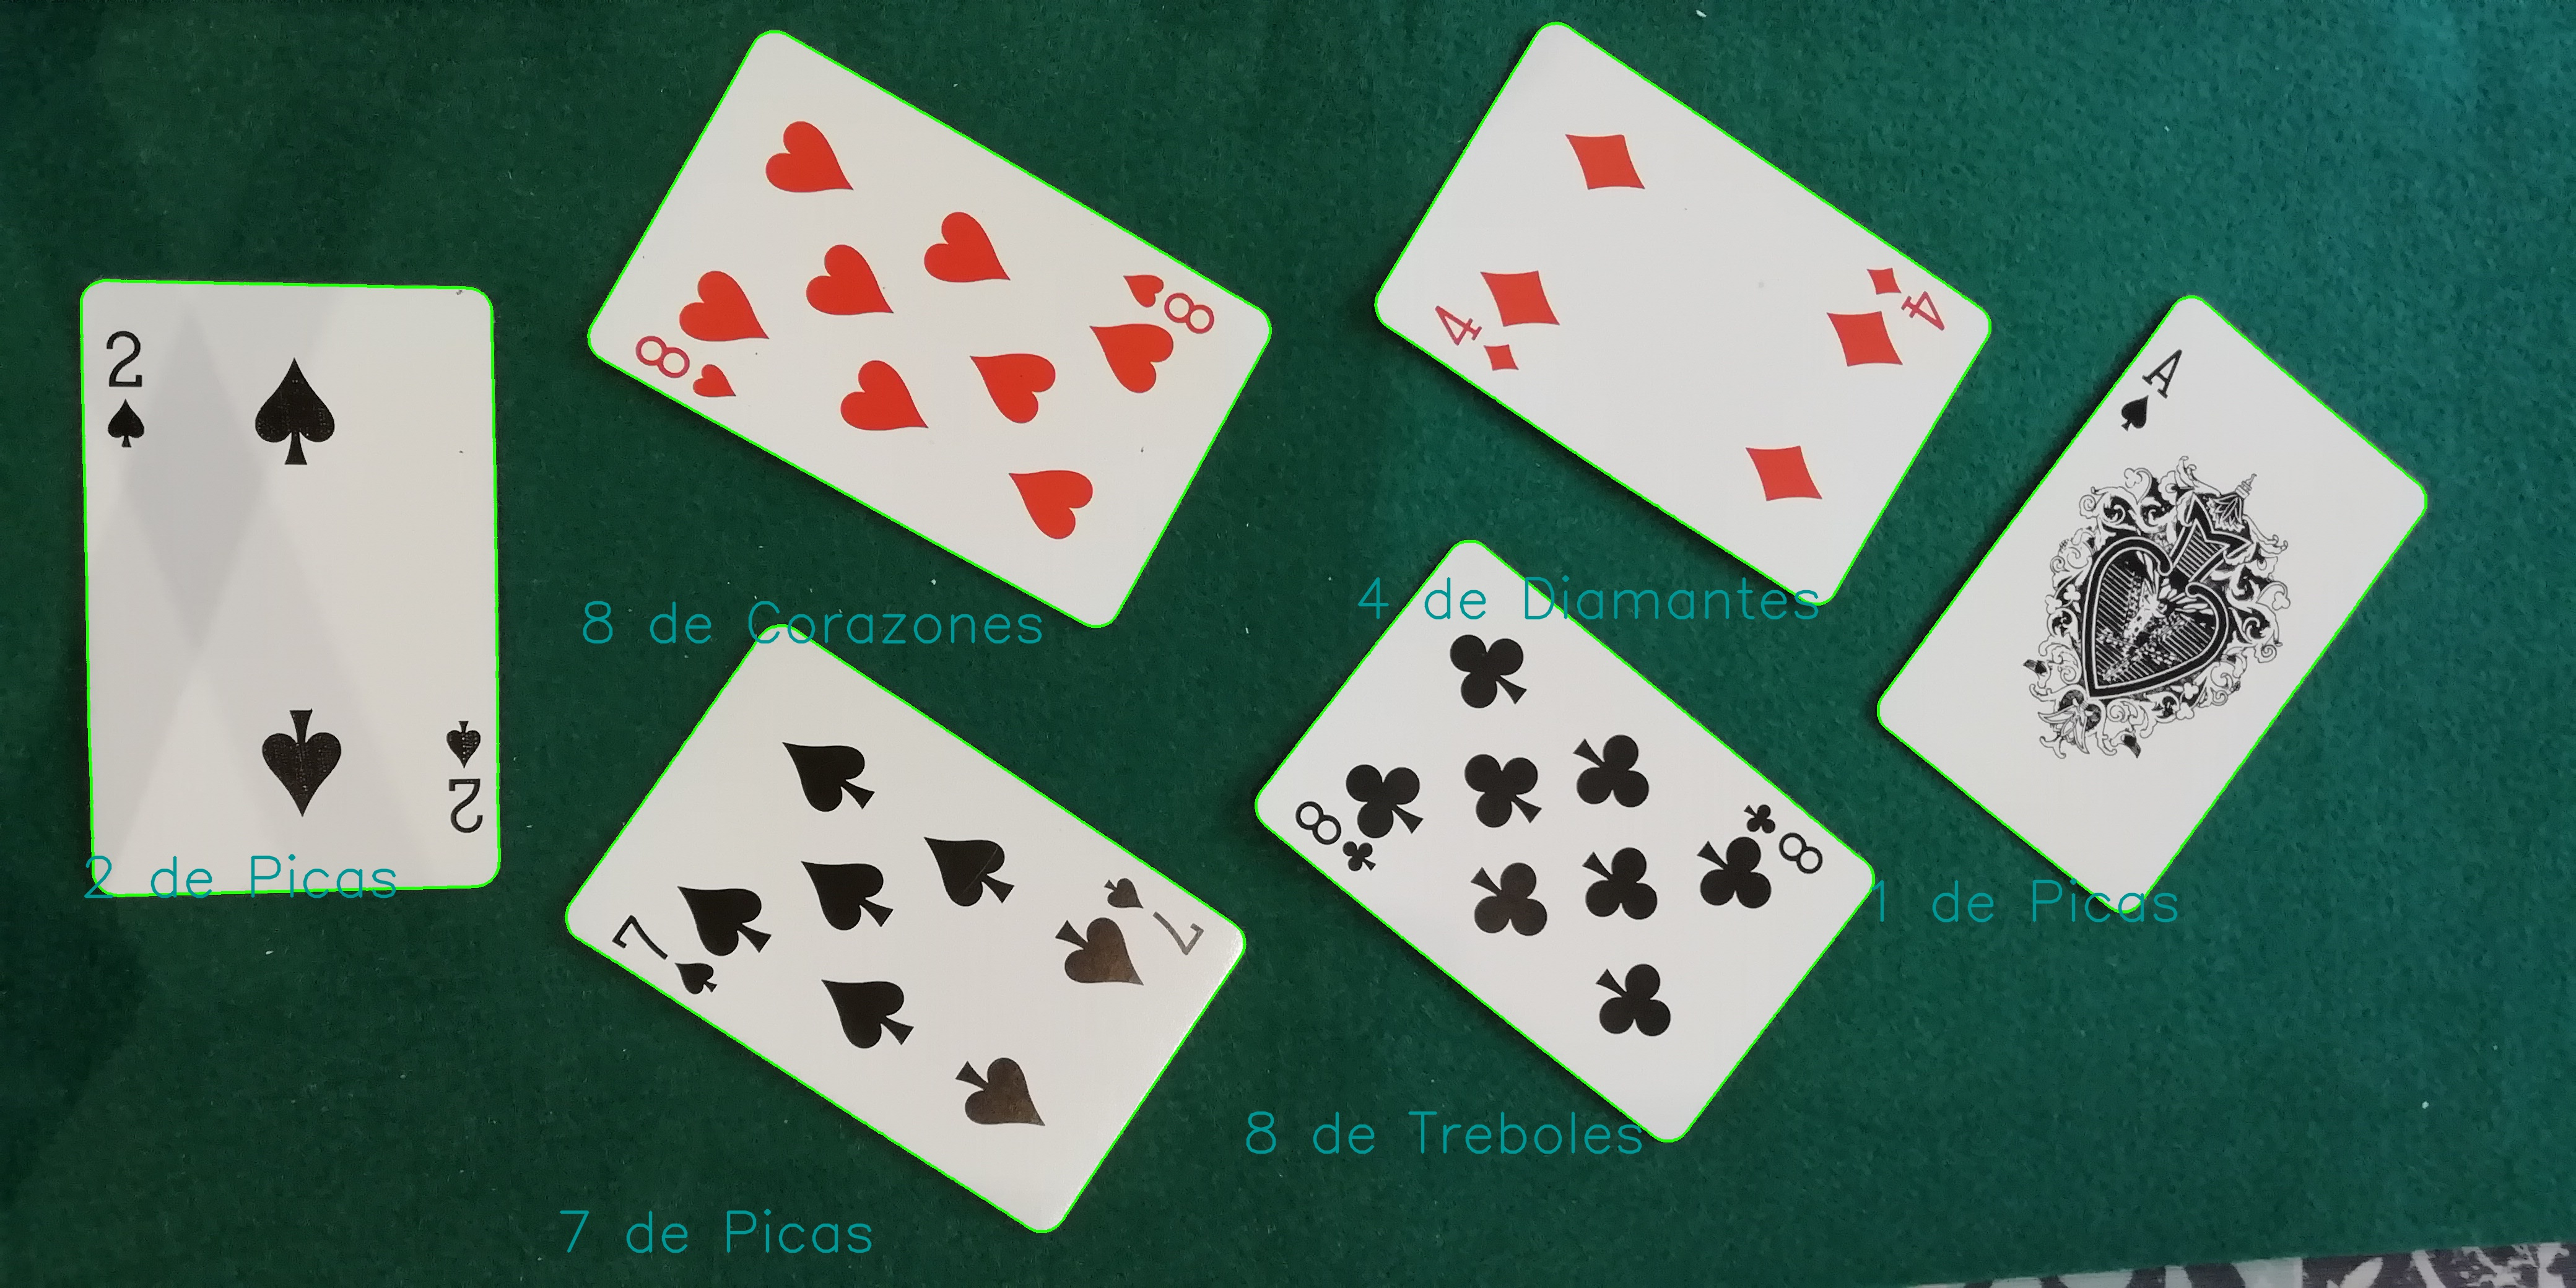

Ejemplo Errores (2,2)

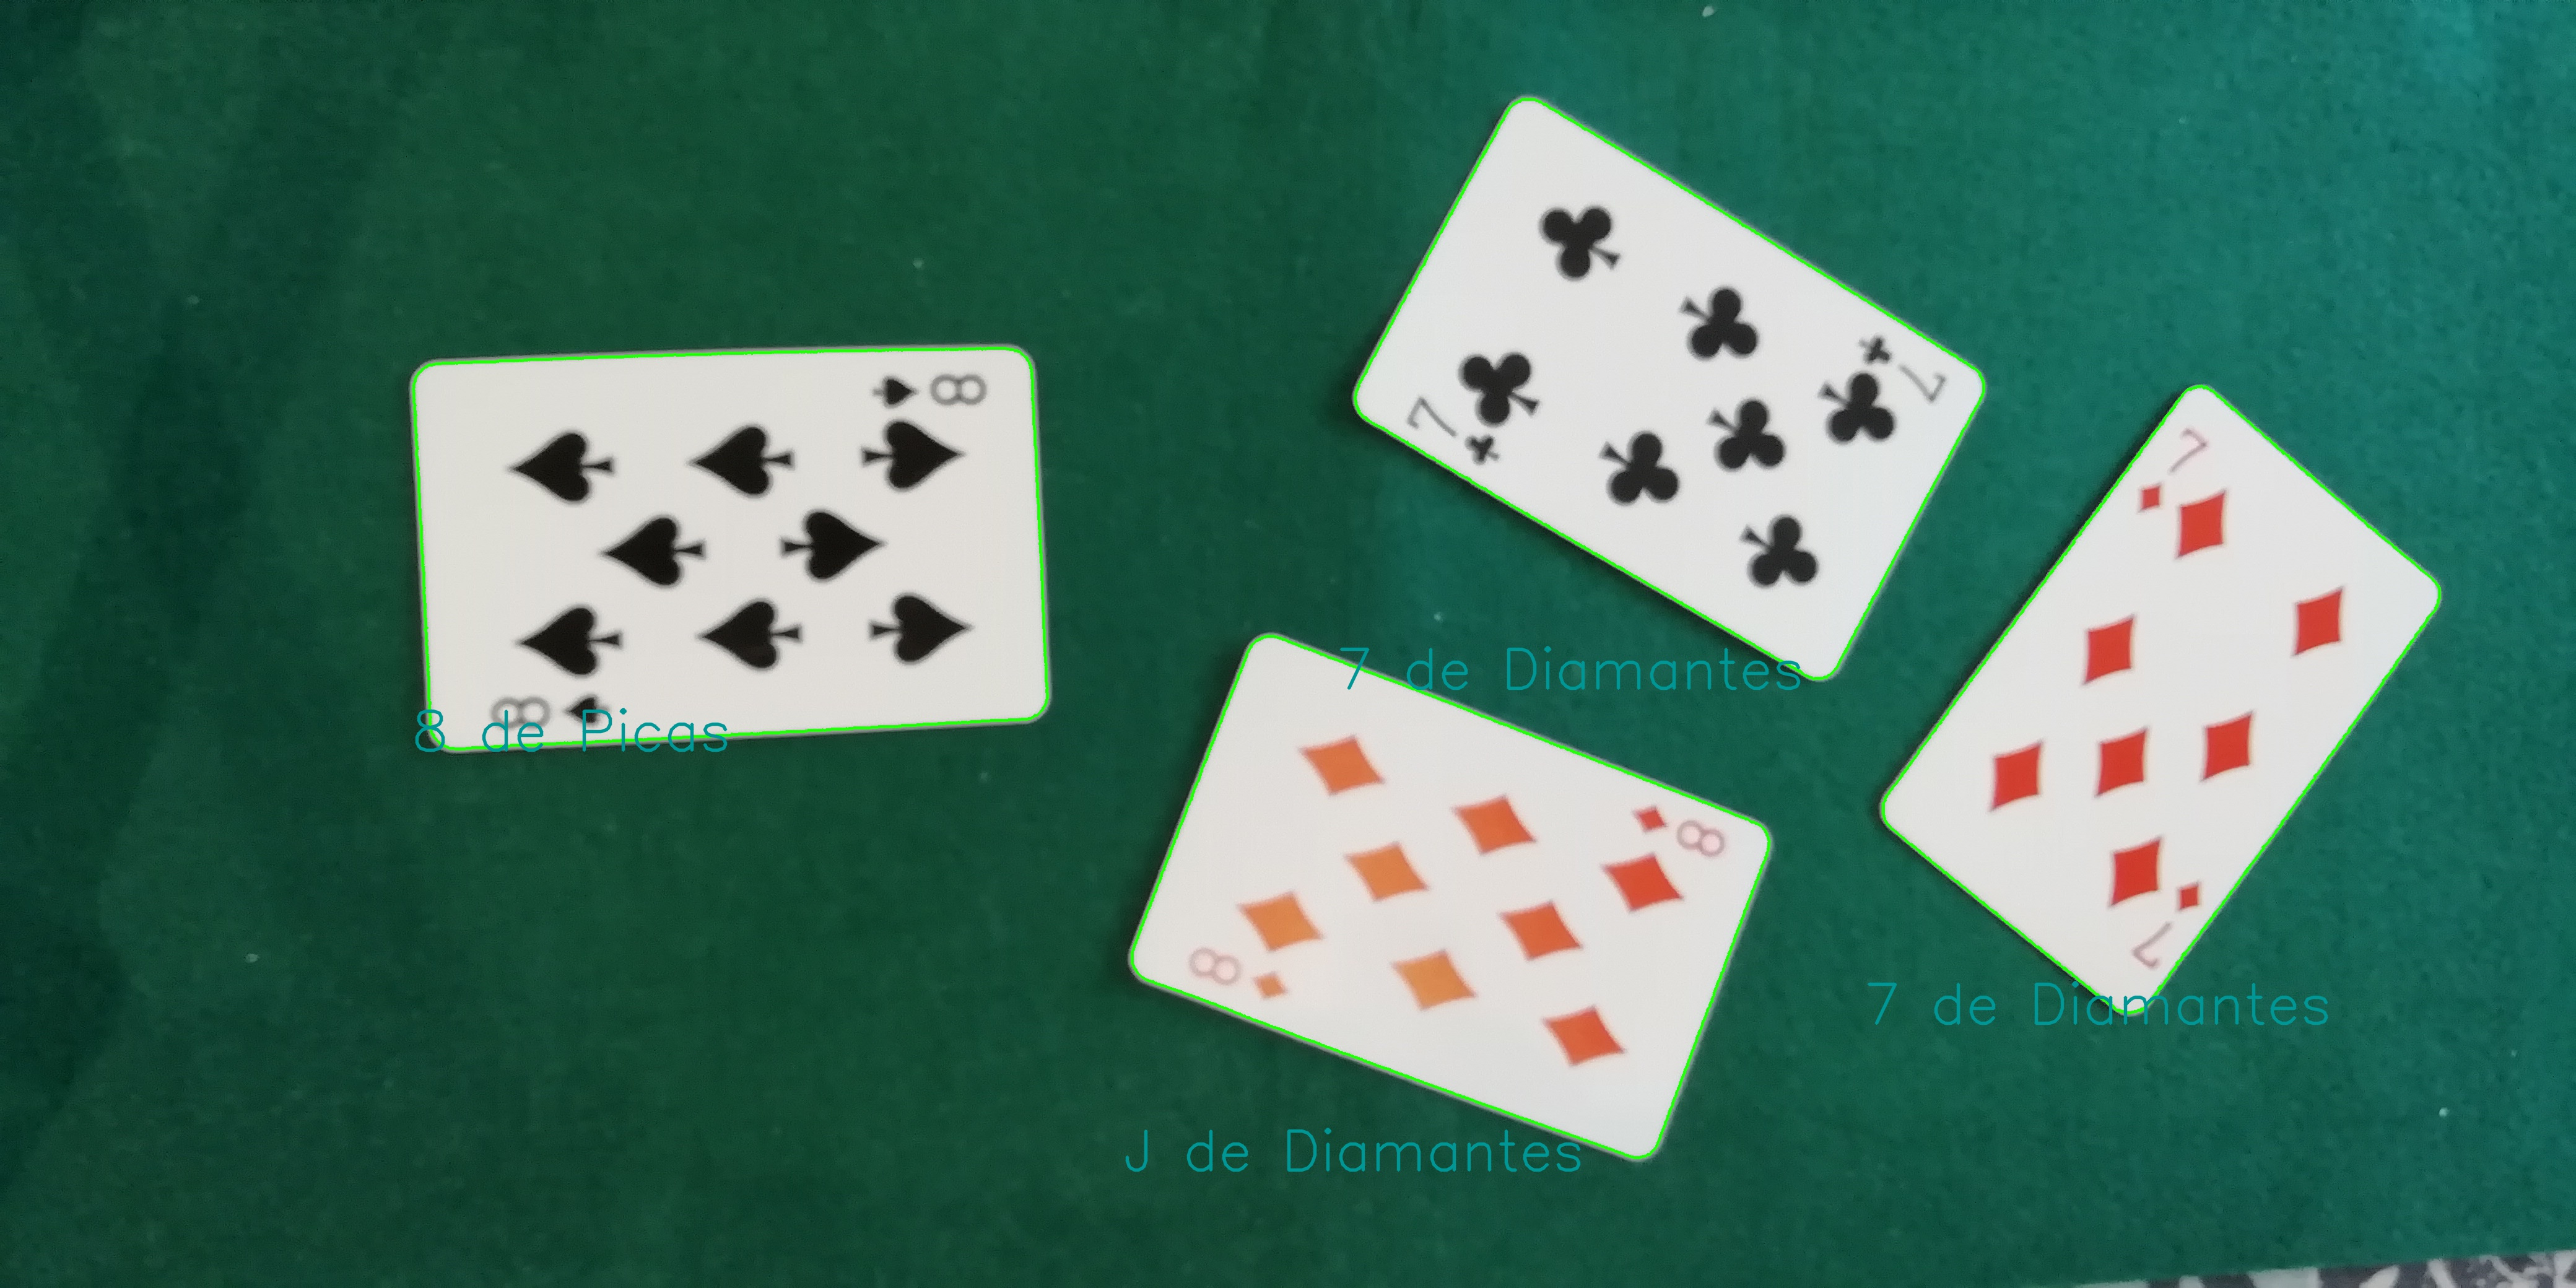

102 aciertos total cartas 104 precision: 0.981